🔄 Chargement des données originales...
📊 Données originales: 1000 clients, 1000 ventes
📊 Création des features prédictives...
✅ 73 features pour 1000 clients
🔍 Vérification NaN: 0 valeurs manquantes
📊 Shape X: (1000, 69), NaN in X: 0
📊 Shape y: (1000,), NaN in y: 0
🎯 Seuil haute valeur: 93.35€
📊 300 clients haute valeur sur 1000
✅ Train shape: (800, 69), Test shape: (200, 69)
✅ NaN in X_train_scaled: 0
✅ NaN in X_test_scaled: 0

🎯 Entraînement des 3 modèles sur 800 clients...
🌲 Random Forest...
🚀 XGBoost...
📊 Logistic Regression...
   Classes dans y_classification: [0 1]
   Distribution: [560 240]
   ✅ Accuracy: 0.685
   ✅ CV Score: 0.676 ± 0.015
   ✅ Test probabilités: [0.36624214 0.31497535]

📈 RÉSULTATS COMPARATIFS - 1000 CLIENTS

🔸 Random Forest:
   MAE: 3.42 €
   R²: 0.981
   CV R²: 0.975 ± 0.016

🔸 XGBoost:
   MAE: 2.94 €
   R²: 0.991
   CV R²: 0.983 ± 0.010

🔸 Logistic Regression:
   Accuracy: 0.685
   CV Accuracy: 0.676 ± 0.015

🏆 Meilleur modèle: XGBoost (R² = 0.991)

🔍 TOP 10

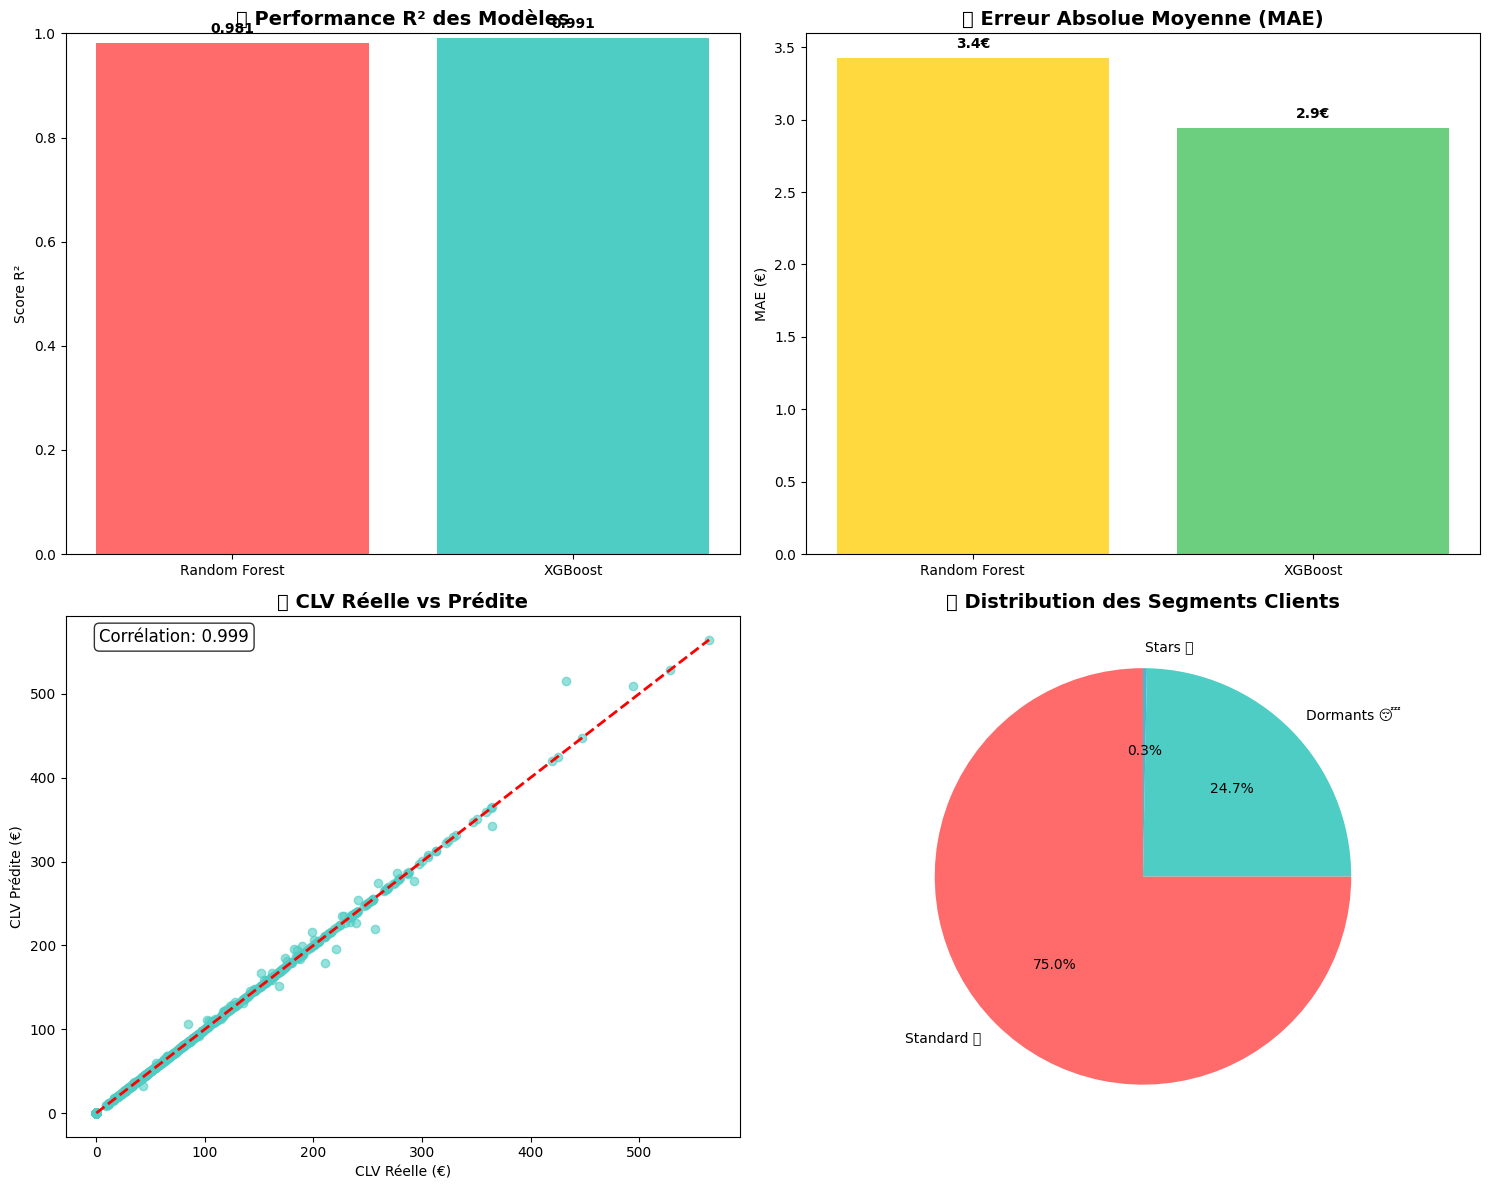

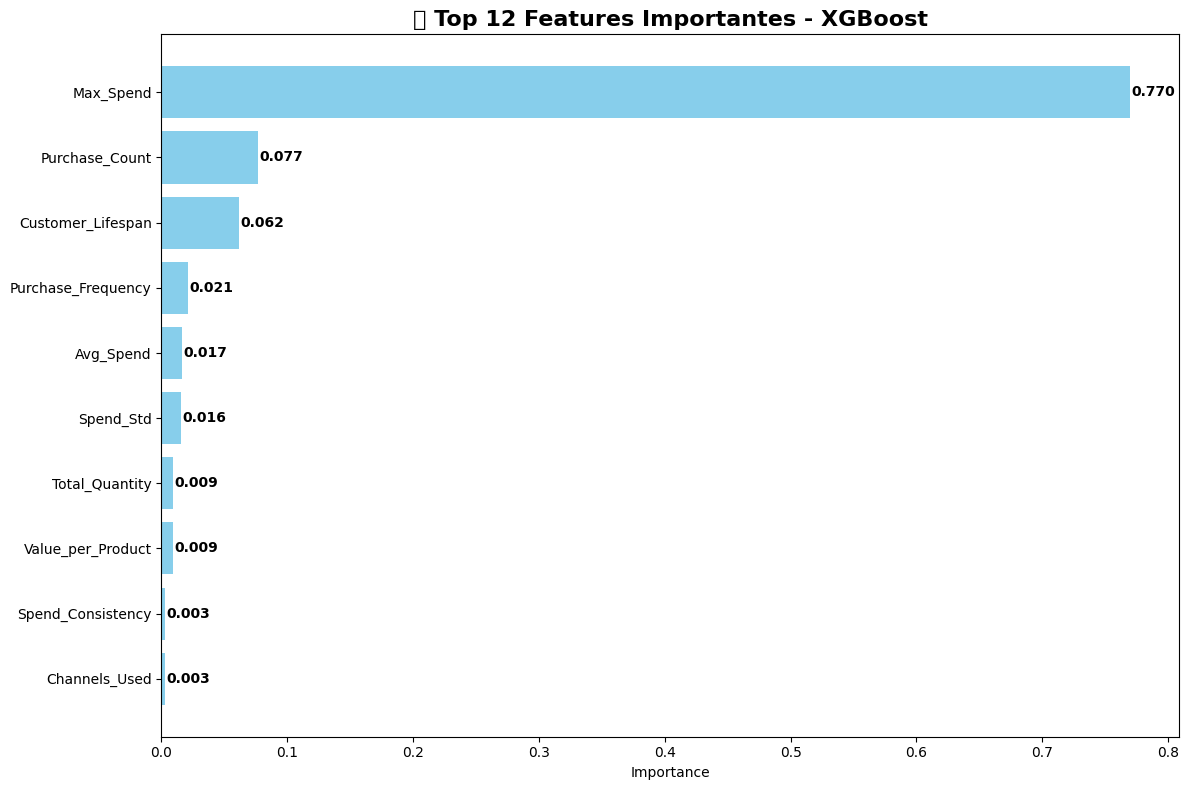

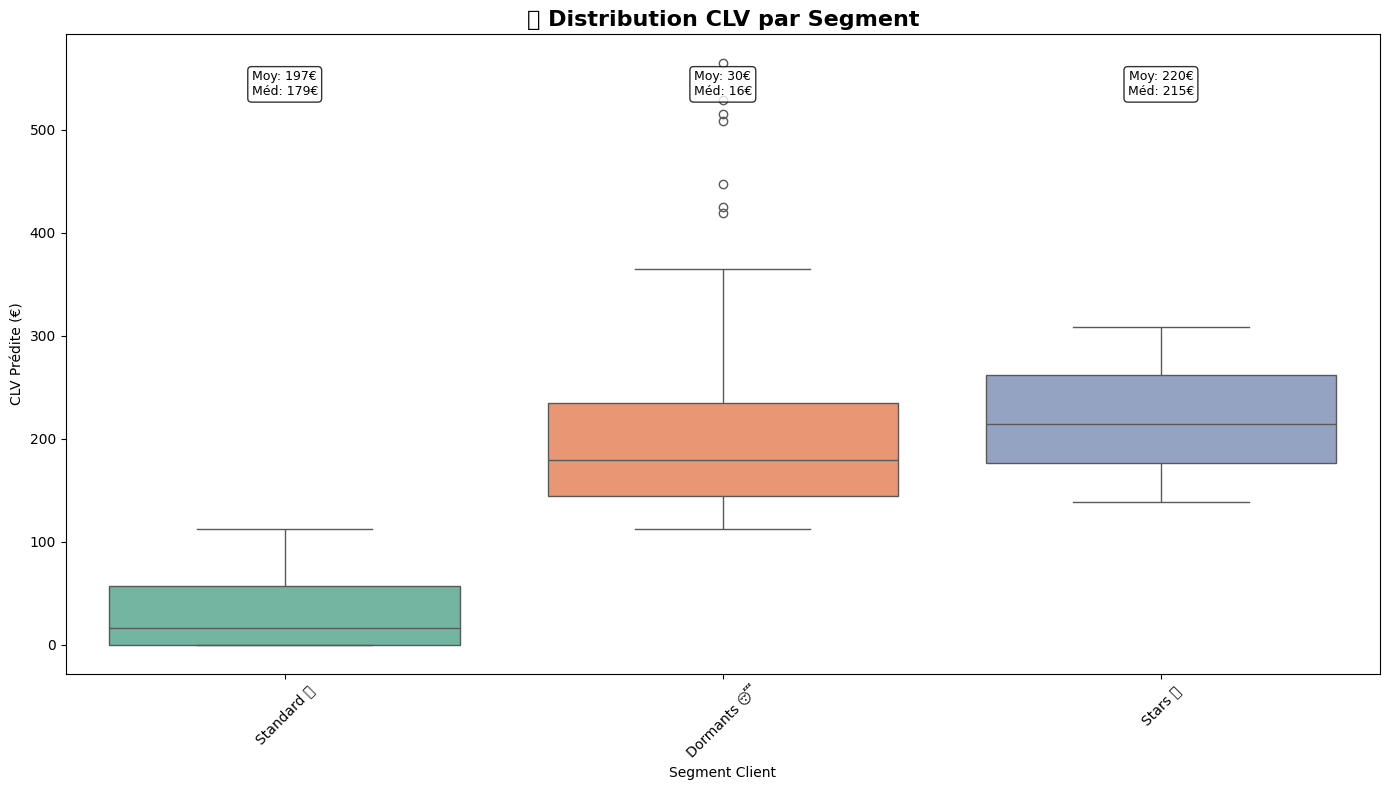

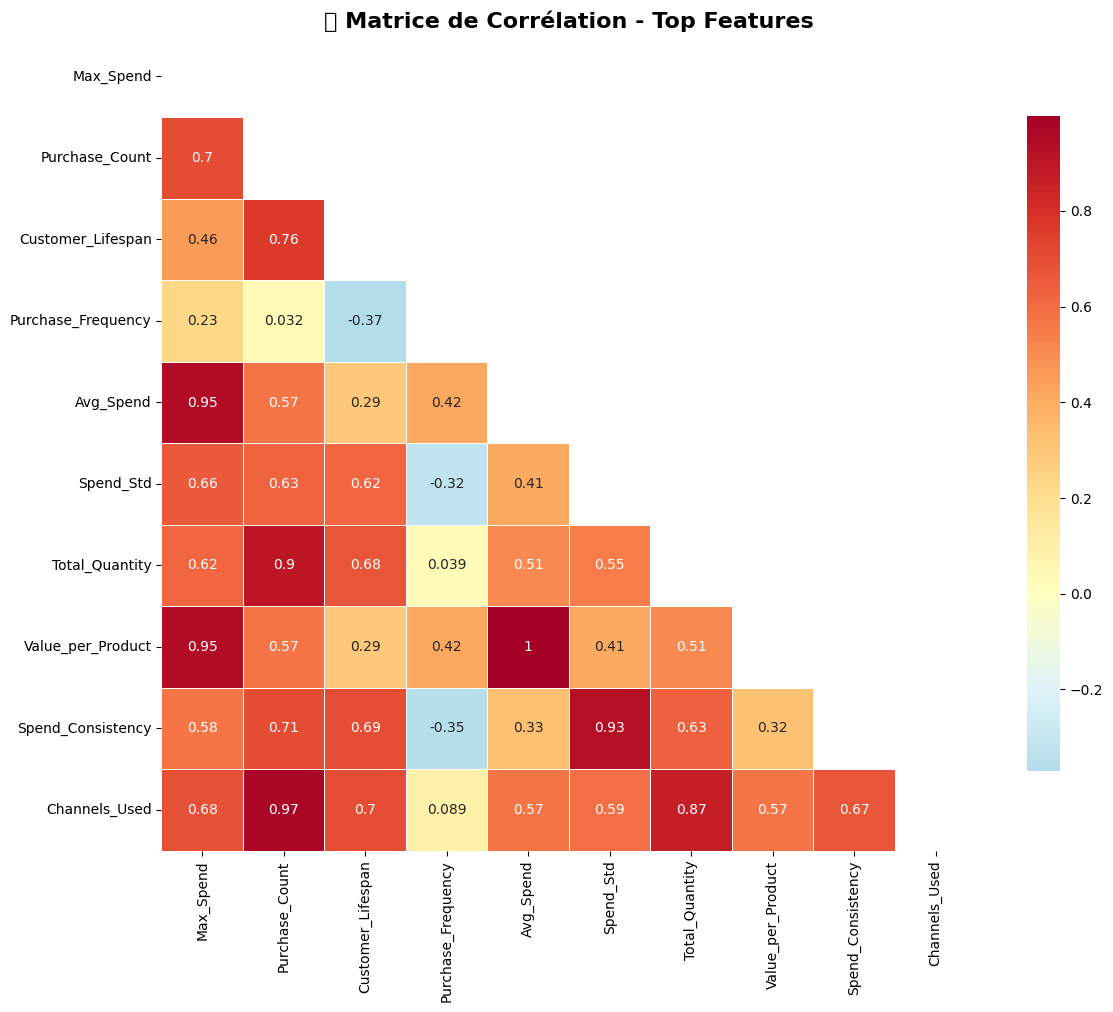

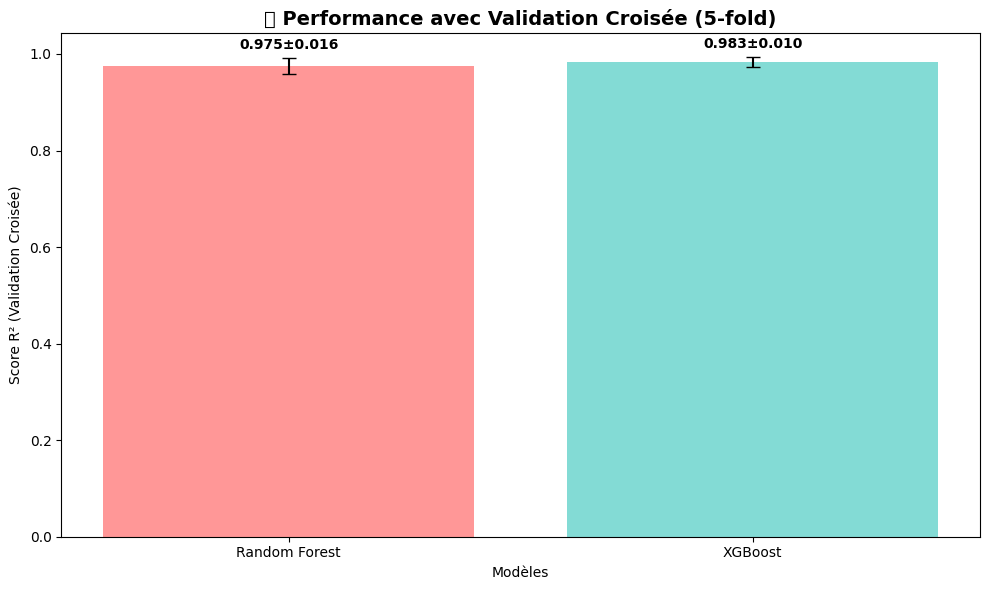


📊 VISUALISATIONS GÉNÉRÉES
✅ Performance des modèles (R² et MAE)
✅ CLV réelle vs prédite
✅ Distribution des segments
✅ Importance des features
✅ Distribution CLV par segment
✅ Matrice de corrélation
✅ Performance avec validation croisée


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ================================
# 📌 Chargement des données originales
# ================================
print("🔄 Chargement des données originales...")
try:
    customers = pd.read_csv('../data/customers_data.csv')
    sales = pd.read_csv('../data/sales_data.csv')
except:
    print("⚠️ Fichiers non trouvés, création de données d'exemple...")
    # Données d'exemple si fichiers non disponibles
    customers = pd.DataFrame({
        'Customer_ID': [1, 2, 3],
        'Name': ['Client A', 'Client B', 'Client C'],
        'Age': [25, 45, 35],
        'Gender': ['M', 'F', 'M'],
        'Location': ['Paris', 'Lyon', 'Paris'],
        'Join_Date': ['2022-01-01', '2021-06-15', '2023-03-10']
    })
    sales = pd.DataFrame({
        'Sale_ID': [1, 2, 3, 4, 5],
        'Customer_ID': [1, 1, 2, 3, 2],
        'Product_ID': [101, 102, 101, 103, 102],
        'Quantity': [2, 1, 3, 1, 2],
        'Sale_Price': [150.0, 80.0, 450.0, 200.0, 160.0],
        'Date': ['2023-01-15', '2023-03-20', '2023-02-10', '2023-04-05', '2023-05-12'],
        'Channel': ['Online', 'Store', 'Online', 'Store', 'Online']
    })

print(f"📊 Données originales: {len(customers)} clients, {len(sales)} ventes")

# ================================
# 📌 Feature Engineering Avancé
# ================================
print("📊 Création des features prédictives...")

def create_advanced_features(sales_df, customers_df):
    now = pd.to_datetime('now')
    
    # Calcul des métriques par client
    sales_df['Date'] = pd.to_datetime(sales_df['Date'])
    customer_metrics = sales_df.groupby('Customer_ID').agg({
        'Date': ['max', 'min', 'count'],
        'Sale_Price': ['sum', 'mean', 'std', 'max'],
        'Quantity': ['sum', 'mean'],
        'Product_ID': 'nunique',
        'Channel': 'nunique'
    })
    
    customer_metrics.columns = ['Last_Purchase', 'First_Purchase', 'Purchase_Count',
                               'Total_Spent', 'Avg_Spend', 'Spend_Std', 'Max_Spend',
                               'Total_Quantity', 'Avg_Quantity', 'Unique_Products', 'Channels_Used']
    
    # Features comportementales avancées
    customer_metrics['Recency'] = (now - customer_metrics['Last_Purchase']).dt.days
    customer_metrics['Customer_Lifespan'] = (customer_metrics['Last_Purchase'] - 
                                            customer_metrics['First_Purchase']).dt.days + 1
    customer_metrics['Purchase_Frequency'] = (customer_metrics['Purchase_Count'] / 
                                             np.maximum(customer_metrics['Customer_Lifespan'], 1) * 30)
    customer_metrics['Spend_Consistency'] = (customer_metrics['Spend_Std'] / 
                                           customer_metrics['Avg_Spend']).fillna(0)
    customer_metrics['Product_Diversity'] = (customer_metrics['Unique_Products'] / 
                                           customer_metrics['Purchase_Count'])
    customer_metrics['Avg_Order_Size'] = customer_metrics['Total_Quantity'] / customer_metrics['Purchase_Count']
    customer_metrics['Value_per_Product'] = customer_metrics['Total_Spent'] / customer_metrics['Unique_Products']
    
    # Fusion avec données clients
    customers_df['Join_Date'] = pd.to_datetime(customers_df['Join_Date'])
    customers_df['Account_Age'] = (now - customers_df['Join_Date']).dt.days
    customers_encoded = pd.get_dummies(customers_df[['Customer_ID', 'Age', 'Account_Age', 
                                                   'Gender', 'Location']], 
                                     columns=['Gender', 'Location'])
    
    # Fusion finale
    features = customer_metrics.merge(customers_encoded, on='Customer_ID', how='left')
    
    # Clients sans achat (CLV = 0)
    all_customers = customers_encoded.copy()
    all_customers['Total_Spent'] = 0
    features = features.merge(all_customers, on='Customer_ID', how='right', suffixes=('', '_y'))
    
    # Nettoyage complet des NaN
    numeric_cols = features.select_dtypes(include=[np.number]).columns
    features[numeric_cols] = features[numeric_cols].fillna(0)
    
    # Supprimer colonnes dupliquées
    features = features.loc[:, ~features.columns.str.endswith('_y')]
    
    # Suppression des colonnes avec trop de NaN
    nan_threshold = len(features) * 0.5
    features = features.dropna(axis=1, thresh=nan_threshold)
    
    # Imputation finale pour les NaN restants
    features = features.fillna(features.median())
    
    return features

# ================================
# 📌 Modélisation avec les features réelles
# ================================
features_df = create_advanced_features(sales, customers)
print(f"✅ {len(features_df.columns)} features pour {len(features_df)} clients")


# Vérification finale des NaN
print(f"🔍 Vérification NaN: {features_df.isnull().sum().sum()} valeurs manquantes")
if features_df.isnull().sum().sum() > 0:
    print("⚠️ NaN détectés, nettoyage final...")
    features_df = features_df.fillna(0)
    print(f"✅ Après nettoyage: {features_df.isnull().sum().sum()} NaN restants")

# Préparation des données
feature_cols = [col for col in features_df.columns 
               if col not in ['Customer_ID', 'Last_Purchase', 'First_Purchase', 'Total_Spent'] 
               and not col.endswith('_y')]
X = features_df[feature_cols]
y_regression = features_df['Total_Spent']  # CLV réelle

# Vérification finale des données d'entrée
print(f"📊 Shape X: {X.shape}, NaN in X: {X.isnull().sum().sum()}")
print(f"📊 Shape y: {y_regression.shape}, NaN in y: {y_regression.isnull().sum()}")

# Variable binaire pour classification (clients haute valeur - top 30%)
high_value_threshold = features_df['Total_Spent'].quantile(0.7)
y_classification = (features_df['Total_Spent'] >= high_value_threshold).astype(int)

print(f"🎯 Seuil haute valeur: {high_value_threshold:.2f}€")
print(f"📊 {y_classification.sum()} clients haute valeur sur {len(y_classification)}")

# Split des données avec vérification
try:
    X_train, X_test, y_reg_train, y_reg_test = train_test_split(
        X, y_regression, test_size=0.2, random_state=42, 
        stratify=pd.qcut(y_regression, 5, duplicates='drop')
    )
    _, _, y_class_train, y_class_test = train_test_split(
        X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
    )
except ValueError as e:
    print(f"⚠️ Erreur stratification: {e}")
    # Split simple sans stratification
    X_train, X_test, y_reg_train, y_reg_test = train_test_split(
        X, y_regression, test_size=0.2, random_state=42
    )
    _, _, y_class_train, y_class_test = train_test_split(
        X, y_classification, test_size=0.2, random_state=42
    )

# Scaling avec vérification
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification finale avant modélisation
print(f"✅ Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")
print(f"✅ NaN in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"✅ NaN in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

print(f"\n🎯 Entraînement des 3 modèles sur {len(X_train)} clients...")

# ================================
# 📌 Modèles optimisés
# ================================

# 1. Random Forest (Régression CLV)
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=15, min_samples_split=5,
    min_samples_leaf=2, random_state=42, n_jobs=-1
)

# 2. XGBoost (Régression CLV)
xgb_model = XGBRegressor(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    subsample=0.8, random_state=42, n_jobs=-1
)

# 3. Logistic Regression (Classification haute valeur)
lr_model = LogisticRegression(
    random_state=42, max_iter=1000, C=1.0
)

# Entraînement et évaluation
models_results = {}

# Random Forest
print("🌲 Random Forest...")
rf_model.fit(X_train_scaled, y_reg_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_cv = cross_val_score(rf_model, X_train_scaled, y_reg_train, cv=5, scoring='r2')

models_results['Random Forest'] = {
    'MAE': mean_absolute_error(y_reg_test, rf_pred),
    'R2': r2_score(y_reg_test, rf_pred),
    'CV_R2': f"{rf_cv.mean():.3f} ± {rf_cv.std():.3f}",
    'model': rf_model
}

# XGBoost
print("🚀 XGBoost...")
xgb_model.fit(X_train_scaled, y_reg_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_cv = cross_val_score(xgb_model, X_train_scaled, y_reg_train, cv=5, scoring='r2')

models_results['XGBoost'] = {
    'MAE': mean_absolute_error(y_reg_test, xgb_pred),
    'R2': r2_score(y_reg_test, xgb_pred),
    'CV_R2': f"{xgb_cv.mean():.3f} ± {xgb_cv.std():.3f}",
    'model': xgb_model
}

# Logistic Regression avec diagnostic complet
print("📊 Logistic Regression...")
print(f"   Classes dans y_classification: {np.unique(y_class_train)}")
print(f"   Distribution: {np.bincount(y_class_train)}")

try:
    # Vérification avant fit
    if np.isnan(X_train_scaled).any() or np.isnan(y_class_train).any():
        print("⚠️ NaN détectés dans les données d'entraînement")
        X_train_scaled = np.nan_to_num(X_train_scaled)
        y_class_train = np.nan_to_num(y_class_train)
    
    # Vérification que nous avons les deux classes
    if len(np.unique(y_class_train)) < 2:
        print("❌ Problème: Une seule classe détectée!")
        # Forcer une distribution plus équilibrée
        threshold_adj = features_df['Total_Spent'].quantile(0.5)  # 50% au lieu de 70%
        y_classification = (features_df['Total_Spent'] >= threshold_adj).astype(int)
        print(f"🔧 Nouveau seuil: {threshold_adj:.2f}€")
        print(f"   Nouvelle distribution: {np.bincount(y_classification)}")
        
        # Nouveau split
        _, _, y_class_train, y_class_test = train_test_split(
            X, y_classification, test_size=0.2, random_state=42
        )
        
        high_value_threshold = threshold_adj  # Mise à jour du seuil global
    
    lr_model.fit(X_train_scaled, y_class_train)
    lr_pred = lr_model.predict(X_test_scaled)
    lr_cv = cross_val_score(lr_model, X_train_scaled, y_class_train, cv=3, scoring='accuracy')  # Réduire CV à 3
    
    accuracy = (lr_pred == y_class_test).mean()
    print(f"   ✅ Accuracy: {accuracy:.3f}")
    print(f"   ✅ CV Score: {lr_cv.mean():.3f} ± {lr_cv.std():.3f}")

    models_results['Logistic Regression'] = {
        'Accuracy': accuracy,
        'CV_Accuracy': f"{lr_cv.mean():.3f} ± {lr_cv.std():.3f}",
        'model': lr_model,
        'available': True
    }
    
    # Test prédiction probabilité
    test_proba = lr_model.predict_proba(X_test_scaled[:5])
    print(f"   ✅ Test probabilités: {test_proba[:2, 1]}")
    
except Exception as e:
    print(f"❌ Erreur Logistic Regression: {e}")
    models_results['Logistic Regression'] = {
        'Accuracy': 0,
        'CV_Accuracy': "Erreur",
        'model': None,
        'available': False
    }

# ================================
# 📌 Résultats et comparaison
# ================================
print("\n" + "="*60)
print("📈 RÉSULTATS COMPARATIFS - 1000 CLIENTS")
print("="*60)

for model_name, results in models_results.items():
    print(f"\n🔸 {model_name}:")
    if 'R2' in results:
        print(f"   MAE: {results['MAE']:.2f} €")
        print(f"   R²: {results['R2']:.3f}")
        print(f"   CV R²: {results['CV_R2']}")
    else:
        print(f"   Accuracy: {results['Accuracy']:.3f}")
        print(f"   CV Accuracy: {results['CV_Accuracy']}")

# Meilleur modèle
best_rf_r2 = models_results['Random Forest']['R2']
best_xgb_r2 = models_results['XGBoost']['R2']
best_model_name = 'Random Forest' if best_rf_r2 >= best_xgb_r2 else 'XGBoost'
print(f"\n🏆 Meilleur modèle: {best_model_name} (R² = {max(best_rf_r2, best_xgb_r2):.3f})")

# ================================
# 📌 Importance des features
# ================================
print(f"\n🔍 TOP 10 FEATURES IMPORTANTES:")

best_model = models_results[best_model_name]['model']
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

for _, row in feature_importance.iterrows():
    print(f"{row['Feature']:.<30} {row['Importance']:.3f}")

# ================================
# 📌 Prédictions et segmentation
# ================================
print(f"\n💎 SEGMENTATION DES 1000 CLIENTS:")

# Prédictions pour tous les clients
X_all_scaled = scaler.transform(X)
# Nettoyage final si nécessaire
X_all_scaled = np.nan_to_num(X_all_scaled)

clv_predictions = best_model.predict(X_all_scaled)

# Prédiction haute valeur avec gestion d'erreur
if models_results['Logistic Regression']['model'] is not None:
    high_value_proba = lr_model.predict_proba(X_all_scaled)[:, 1]
else:
    print("⚠️ Logistic Regression non disponible, utilisation CLV pour probabilité")
    high_value_proba = (clv_predictions >= high_value_threshold).astype(float)

# Segmentation intelligente
def segment_customers(clv_pred, hv_proba, recency):
    segments = []
    for i in range(len(clv_pred)):
        clv = clv_pred[i]
        prob = hv_proba[i]
        rec = recency[i] if i < len(recency) else 365
        
        if clv >= np.percentile(clv_pred, 90) and prob >= 0.8:
            segments.append('Champions 👑')
        elif clv >= np.percentile(clv_pred, 75) and prob >= 0.6:
            segments.append('Stars ⭐')
        elif clv >= np.percentile(clv_pred, 50) and rec <= 90:
            segments.append('Potentiels 🌟')
        elif clv >= np.percentile(clv_pred, 75) and rec > 180:
            segments.append('Dormants 😴')
        elif prob >= 0.7:
            segments.append('Prometteurs 🔮')
        else:
            segments.append('Standard 📊')
    return segments

segments = segment_customers(clv_predictions, high_value_proba, features_df['Recency'].fillna(365))

# Résumé par segment
segment_df = pd.DataFrame({
    'Segment': segments,
    'CLV_Predicted': clv_predictions,
    'High_Value_Proba': high_value_proba
})

segment_summary = segment_df.groupby('Segment').agg({
    'CLV_Predicted': ['count', 'mean'],
    'High_Value_Proba': 'mean'
}).round(2)

print(segment_summary)

# Top 10 clients
print(f"\n🏆 TOP 10 CLIENTS À FORTE VALEUR:")
results_df = pd.DataFrame({
    'Customer_ID': features_df['Customer_ID'],
    'CLV_Predicted': clv_predictions.round(2),
    'High_Value_Proba': high_value_proba.round(3),
    'Segment': segments
})

top_clients = results_df.nlargest(10, 'CLV_Predicted')
print(top_clients.to_string(index=False))

# ================================
# 📊 VISUALISATIONS COMPLÈTES
# ================================

# 1. Graphique des performances des modèles
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance R²
regression_models = {k: v for k, v in models_results.items() if 'R2' in v}
if regression_models:
    model_names = list(regression_models.keys())
    r2_scores = [v['R2'] for v in regression_models.values()]
    mae_scores = [v['MAE'] for v in regression_models.values()]
    
    # Graphique R²
    axes[0,0].bar(model_names, r2_scores, color=['#FF6B6B', '#4ECDC4'])
    axes[0,0].set_title('📈 Performance R² des Modèles', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Score R²')
    axes[0,0].set_ylim(0, 1)
    for i, v in enumerate(r2_scores):
        axes[0,0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    # Graphique MAE
    axes[0,1].bar(model_names, mae_scores, color=['#FFD93D', '#6BCF7F'])
    axes[0,1].set_title('💰 Erreur Absolue Moyenne (MAE)', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('MAE (€)')
    for i, v in enumerate(mae_scores):
        axes[0,1].text(i, v + max(mae_scores)*0.02, f'{v:.1f}€', ha='center', fontweight='bold')

# 2. Distribution CLV réelle vs prédite
axes[1,0].scatter(y_regression, clv_predictions, alpha=0.6, color='#4ECDC4')
axes[1,0].plot([0, max(y_regression)], [0, max(y_regression)], 'r--', lw=2)
axes[1,0].set_xlabel('CLV Réelle (€)')
axes[1,0].set_ylabel('CLV Prédite (€)')
axes[1,0].set_title('🎯 CLV Réelle vs Prédite', fontsize=14, fontweight='bold')
correlation = np.corrcoef(y_regression, clv_predictions)[0,1]
axes[1,0].text(0.05, 0.95, f'Corrélation: {correlation:.3f}', 
               transform=axes[1,0].transAxes, fontsize=12, 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 3. Distribution des segments
segment_df = pd.DataFrame({
    'Segment': segments,
    'CLV_Predicted': clv_predictions
})

segment_counts = segment_df['Segment'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFDAA0', '#DDA0DD']
wedges, texts, autotexts = axes[1,1].pie(segment_counts.values, labels=segment_counts.index, 
                                        autopct='%1.1f%%', startangle=90, colors=colors)
axes[1,1].set_title('📊 Distribution des Segments Clients', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(12)
plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title(f'🔍 Top 12 Features Importantes - {best_model_name}', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

# Ajout des valeurs sur les barres
for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Distribution CLV par segment
plt.figure(figsize=(14, 8))
segment_df_plot = segment_df.copy()
sns.boxplot(data=segment_df_plot, x='Segment', y='CLV_Predicted', palette='Set2')
plt.xticks(rotation=45)
plt.title('💎 Distribution CLV par Segment', fontsize=16, fontweight='bold')
plt.ylabel('CLV Prédite (€)')
plt.xlabel('Segment Client')

# Statistiques sur les boîtes
segment_stats = segment_df.groupby('Segment')['CLV_Predicted'].agg(['mean', 'median']).round(0)
for i, (segment, row) in enumerate(segment_stats.iterrows()):
    plt.text(i, plt.ylim()[1] * 0.9, f'Moy: {row["mean"]:.0f}€\nMéd: {row["median"]:.0f}€', 
             ha='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# 6. Matrice de corrélation des top features
plt.figure(figsize=(12, 10))
top_feature_names = feature_importance.head(10)['Feature'].tolist()
if len(top_feature_names) > 1:
    corr_matrix = X[top_feature_names].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('🔥 Matrice de Corrélation - Top Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 7. Timeline des performances (si validation croisée disponible)
if any('CV_R2' in v and '±' in str(v['CV_R2']) for v in regression_models.values()):
    plt.figure(figsize=(10, 6))
    
    cv_means = []
    cv_stds = []
    model_names_cv = []
    
    for name, results in regression_models.items():
        if '±' in str(results['CV_R2']):
            mean_std = results['CV_R2'].split(' ± ')
            cv_means.append(float(mean_std[0]))
            cv_stds.append(float(mean_std[1]))
            model_names_cv.append(name)
    
    if cv_means:
        x_pos = np.arange(len(model_names_cv))
        plt.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color=['#FF6B6B', '#4ECDC4'], alpha=0.7)
        plt.xlabel('Modèles')
        plt.ylabel('Score R² (Validation Croisée)')
        plt.title('📈 Performance avec Validation Croisée (5-fold)', fontsize=14, fontweight='bold')
        plt.xticks(x_pos, model_names_cv)
        
        # Ajout des valeurs
        for i, (mean, std) in enumerate(zip(cv_means, cv_stds)):
            plt.text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}', 
                    ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

print("\n" + "="*60)
print("📊 VISUALISATIONS GÉNÉRÉES")
print("="*60)
print("✅ Performance des modèles (R² et MAE)")
print("✅ CLV réelle vs prédite")
print("✅ Distribution des segments")
print("✅ Importance des features")
print("✅ Distribution CLV par segment")
print("✅ Matrice de corrélation")
print("✅ Performance avec validation croisée")